In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.spatial import cKDTree

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

## Create a ENSEMBLE and export as Netcdf

In [2]:
yy_s, yy_e = 2002, 2023
years_num = yy_e - yy_s + 1

npix = 2
acf = 'mar'
cor = 'pearson'

In [3]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [5]:
# CMORPH data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_corrected.nc')
DATA_CM = xr.open_dataset(data_dir)
time_year = DATA_CM.year.values
Tr = DATA_CM.Tr.values
print(f'Return period: {Tr[3]}')

lon2d_CM, lat2d_CM = np.meshgrid(DATA_CM.lon.values, DATA_CM.lat.values)

Return period: 50


In [6]:
# ERA5 data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_ER = xr.open_dataset(data_dir)

lon2d_ER, lat2d_ER = np.meshgrid(DATA_ER.lon.values, DATA_ER.lat.values)

In [7]:
## GSMaP data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_GS = xr.open_dataset(data_dir)

lon2d_GS, lat2d_GS = np.meshgrid(DATA_GS.lon.values, DATA_GS.lat.values)

In [8]:
# MSWEP data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_MS = xr.open_dataset(data_dir)

lon2d_MS, lat2d_MS = np.meshgrid(DATA_MS.lon.values, DATA_MS.lat.values)

In [9]:
# IMERG data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_IM = xr.open_dataset(data_dir)
lat_IM = DATA_IM.lat.values
lon_IM = DATA_IM.lon.values

lon2d_IM, lat2d_IM = np.meshgrid(DATA_IM.lon.values, DATA_IM.lat.values)

In [10]:
## CHIRPS data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_CHIRPS_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_CH = xr.open_dataset(data_dir)
lat_CH = DATA_CH.lat.values
lon_CH = DATA_CH.lon.values

lon2d_CH, lat2d_CH = np.meshgrid(DATA_CH.lon.values, DATA_CH.lat.values)

In [11]:
def get_nearest_values(ref_lat2d, ref_lon2d, target_lat2d, target_lon2d, target_data):
    """
    Para cada punto en la malla de referencia, busca el valor más cercano en la malla objetivo.
    """
    ny, nx = ref_lat2d.shape
    ref_points = np.column_stack((ref_lat2d.ravel(), ref_lon2d.ravel()))
    target_points = np.column_stack((target_lat2d.ravel(), target_lon2d.ravel()))
    tree = cKDTree(target_points)
    _, idx = tree.query(ref_points)
    matched_values = target_data.ravel()[idx]
    return matched_values.reshape(ny, nx)

In [12]:
ntimes = DATA_IM.NYd.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_NYd = DATA_IM.NYd.values[i, :, :]
    MS_NYd = DATA_MS.NYd.values[i, :, :]
    GS_NYd = DATA_GS.NYd.values[i, :, :]
    ER_NYd = DATA_ER.NYd.values[i, :, :]
    CM_NYd = DATA_CM.NYd.values[i, :, :]
    CH_NYd = DATA_CH.NYd.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_NYd)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_NYd)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_NYd)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_NYd)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_NYd)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_NYd
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest
    IM_remapped[i, :, :] = IM_nearest 

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)

# Calcular ensemble
NYd_ensemble_mean   = np.nanmean(stacked_all, axis=0)
NYd_ensemble_median = np.nanmedian(stacked_all, axis=0)

In [13]:
ntimes = DATA_IM.CYd.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_CYd = DATA_IM.CYd.values[i, :, :]
    MS_CYd = DATA_MS.CYd.values[i, :, :]
    GS_CYd = DATA_GS.CYd.values[i, :, :]
    ER_CYd = DATA_ER.CYd.values[i, :, :]
    CM_CYd = DATA_CM.CYd.values[i, :, :]
    CH_CYd = DATA_CH.CYd.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_CYd)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_CYd)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_CYd)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_CYd)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_CYd)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_CYd
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest
    IM_remapped[i, :, :] = IM_nearest 

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)

# Calcular ensemble
CYd_ensemble_mean   = np.nanmean(stacked_all, axis=0)
CYd_ensemble_median = np.nanmedian(stacked_all, axis=0)

In [14]:
ntimes = DATA_IM.WYd.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_WYd = DATA_IM.WYd.values[i, :, :]
    MS_WYd = DATA_MS.WYd.values[i, :, :]
    GS_WYd = DATA_GS.WYd.values[i, :, :]
    ER_WYd = DATA_ER.WYd.values[i, :, :]
    CM_WYd = DATA_CM.WYd.values[i, :, :]
    CH_CYd = DATA_CH.WYd.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_WYd)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_WYd)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_WYd)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_WYd)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_WYd)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_CYd
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest   
    IM_remapped[i, :, :] = IM_nearest

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)

# Calcular ensemble
WYd_ensemble_mean   = np.nanmean(stacked_all, axis=0)
WYd_ensemble_median = np.nanmedian(stacked_all, axis=0)

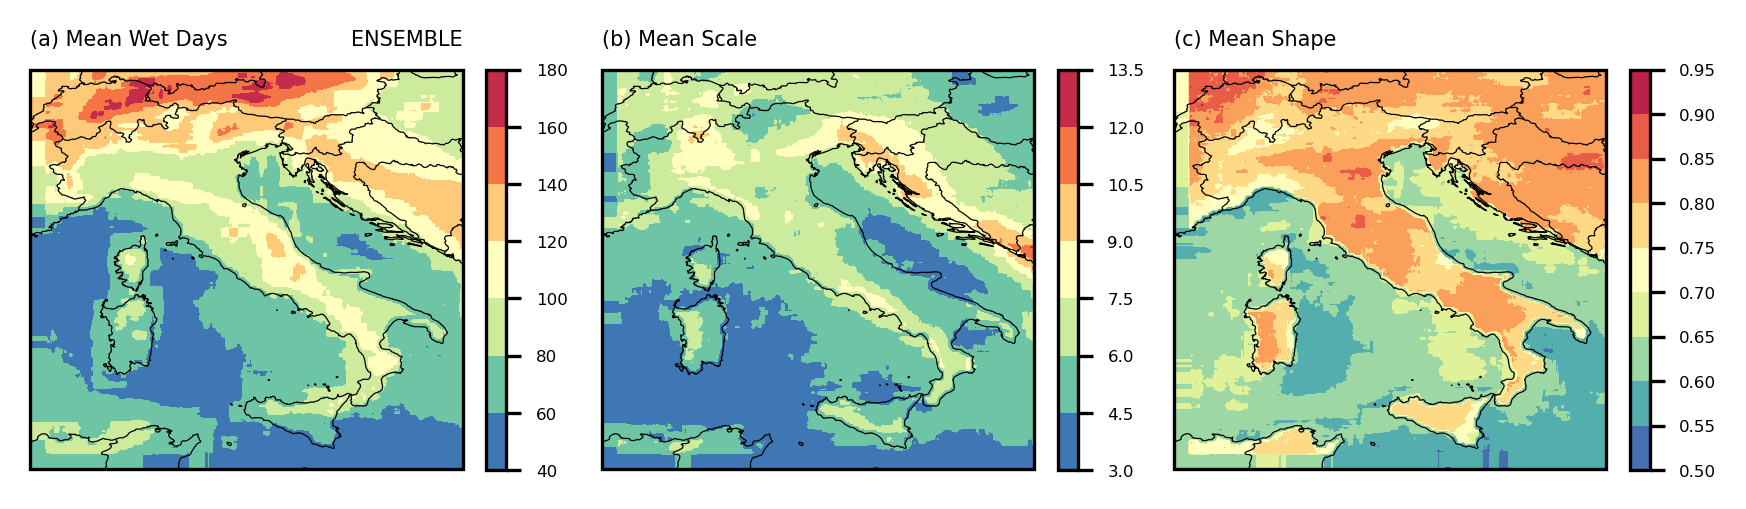

In [15]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(NYd_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean Wet Days', fontsize=5, loc='left')
ax1.set_title(f'ENSEMBLE', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(CYd_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Mean Scale', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(WYd_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Mean Shape', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.15)

In [19]:
ENSEMBLE_Mev_d = ART_down.pre_quantiles_array(
                        NYd_ensemble_mean, 
                        CYd_ensemble_mean, 
                        WYd_ensemble_mean, 
                        Tr, 
                        lat_CH, lon_CH, 
                        1)

In [24]:
ENSEMBLE_Mev_d.shape, NYd_ensemble_mean.shape

((6, 240, 260), (22, 240, 260))

In [28]:
ENSEMBLE_xr = xr.Dataset(data_vars={
                    "NYd": (("year","lat","lon"), NYd_ensemble_mean),
                    "CYd": (("year","lat","lon"), CYd_ensemble_mean),
                    "WYd": (("year","lat","lon"), WYd_ensemble_mean),
                    "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mev_d)
                    },
                    coords={'year': time_year, 'Tr':Tr, 'lat': lat_CH, 'lon': lon_CH},
                    attrs=dict(description=f"ENSEMBLE of the downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid",))

ENSEMBLE_xr.NYd.attrs["units"] = "days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Shape"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [29]:
PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/5_DOWN/ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc


In [ ]:
sys.exit()

SystemExit: 

## Manual method for compare 

In [ ]:
ENSEMBLE_manual = np.zeros_like(DATA_IM.Mev_d.values)
for i in range(len(lat_IM)):
    for j in range(len(lon_IM)):
        IM_vector = DATA_IM.Mev_d.values[:,i,j]

        distances = ART_pre.haversine(lat2d_CM, lon2d_CM, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        CM_vector = DATA_CM.Mev_d.values[:,min_index[0],min_index[1]]

        distances = ART_pre.haversine(lat2d_ER, lon2d_ER, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        ER_vector = DATA_ER.Mev_d.values[:,min_index[0],min_index[1]]

        distances = ART_pre.haversine(lat2d_GS, lon2d_GS, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        GS_vector = DATA_GS.Mev_d.values[:,min_index[0],min_index[1]]

        distances = ART_pre.haversine(lat2d_MS, lon2d_MS, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        MS_vector = DATA_MS.Mev_d.values[:,min_index[0],min_index[1]]

        ENSEMBLE_manual[:,i,j] = np.nanmean([IM_vector, CM_vector, ER_vector, GS_vector, MS_vector], axis=0)

Text(1.0, 1.0, 'Manual')

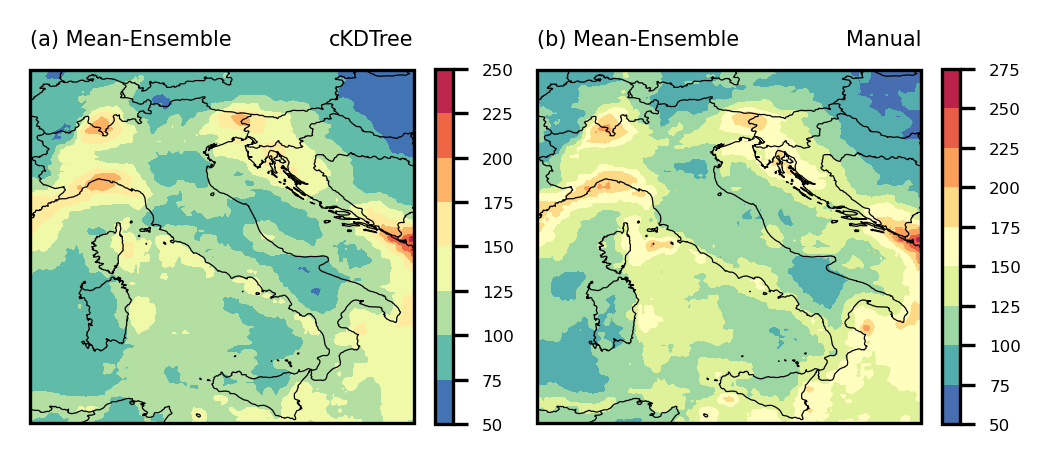

In [ ]:
index = 3

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,6),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, ENSEMBLE_Mev_d[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'cKDTree', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, ENSEMBLE_manual[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Manual', fontsize=5, loc='right')